Before modeling, one last step has to be accomplished: 

Feature scaling
Options applied:
- StandardScaler → zero mean, unit variance (good for linear models, PCA)
- MinMaxScaler → values scaled to [0, 1] (good for neural nets, interpretable ranges)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# Load dataset 
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")

# Select features to scale
features_to_scale = ["age", "juv_misd_count", "juv_fel_count", "priors_count"]

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply scaling
df_standard_scaled = df.copy()
df_standard_scaled[features_to_scale] = standard_scaler.fit_transform(df[features_to_scale])

df_minmax_scaled = df.copy()
df_minmax_scaled[features_to_scale] = minmax_scaler.fit_transform(df[features_to_scale])

# Save both scaled versions
df_standard_scaled.to_csv("../data/compas_scaled_standard.csv", index=False)
df_minmax_scaled.to_csv("../data/compas_scaled_minmax.csv", index=False)

print("Scaling complete. Files saved:")
print("- compas_scaled_standard.csv")
print("- compas_scaled_minmax.csv")


Scaling complete. Files saved:
- compas_scaled_standard.csv
- compas_scaled_minmax.csv


Feature transformation: 

Before transforming features to fit normal distributions, we have to identify the underlying distributions. Let's try log-normal through plotting: If the result is more bell-shaped, log-normal is likely the distribution.

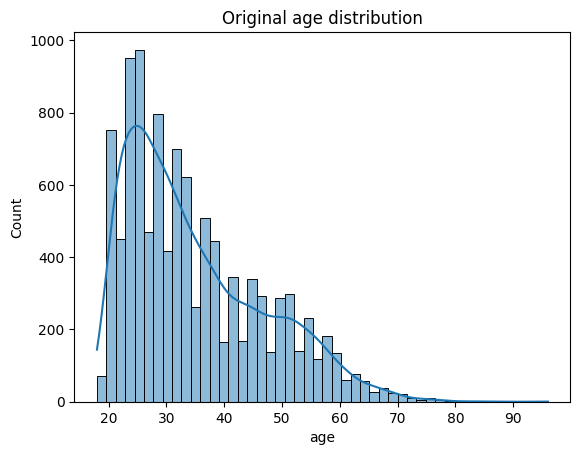

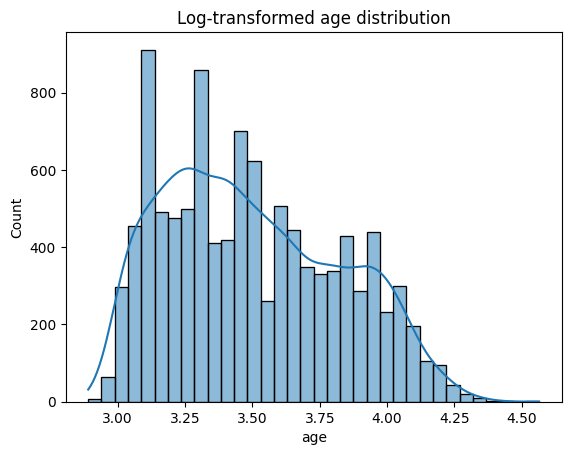

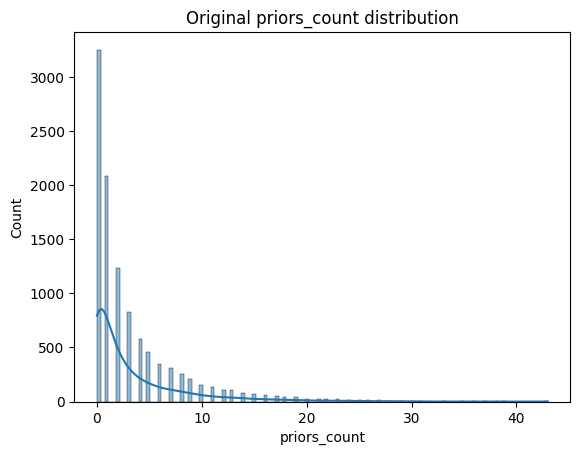

c:\Users\wastl\modelengineering\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


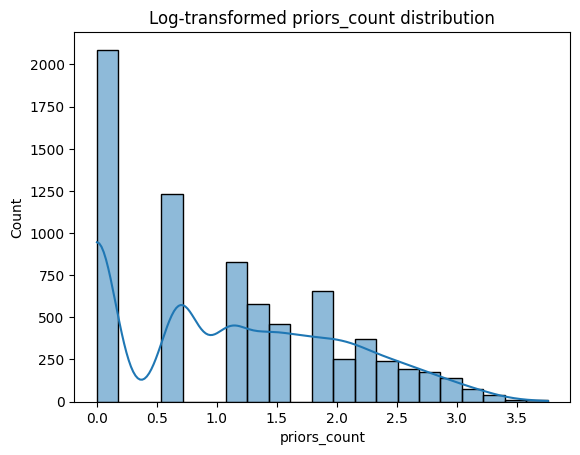

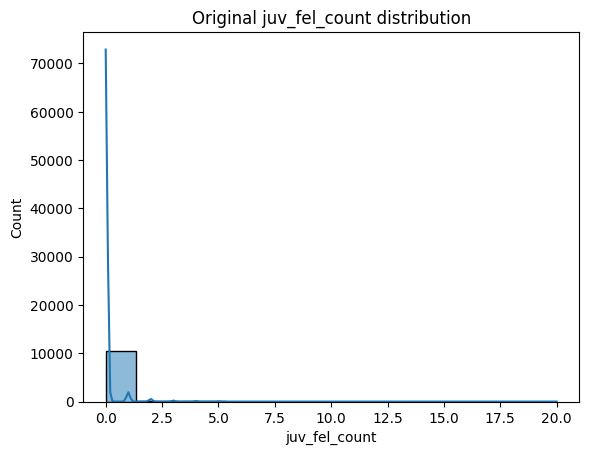

c:\Users\wastl\modelengineering\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


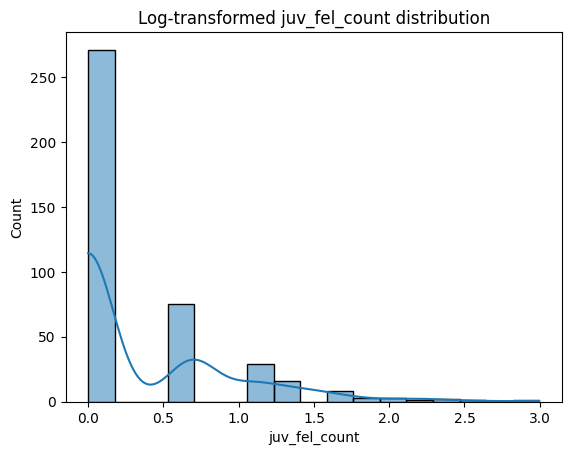

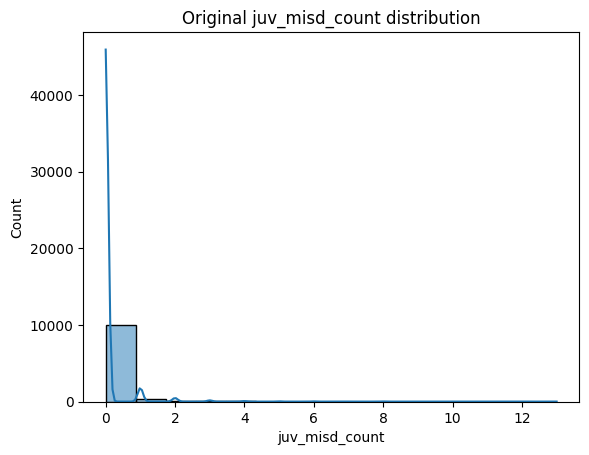

c:\Users\wastl\modelengineering\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


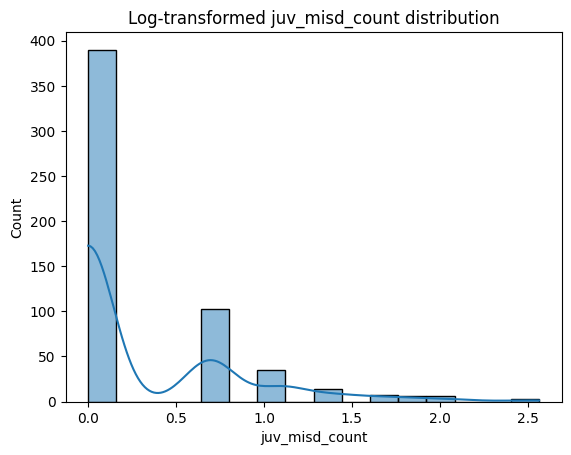

In [88]:
# Plot original age
sns.histplot(df["age"], kde=True)
plt.title("Original age distribution")
plt.show()

# Plot log-transformed age
sns.histplot(np.log(df["age"]), kde=True)
plt.title("Log-transformed age distribution")
plt.savefig("../reports/log-transformed_age_dist.png")
plt.show()
plt.close()

# Plot original priors_count
sns.histplot(df["priors_count"], kde=True)
plt.title("Original priors_count distribution")
plt.show()

# Plot log-transformed priors_count
sns.histplot(np.log(df["priors_count"]), kde=True)
plt.title("Log-transformed priors_count distribution")
plt.savefig("../reports/log-transformed_priors_count_dist.png")
plt.show()
plt.close()

# Plot original juv_fel_count
sns.histplot(df["juv_fel_count"], kde=True)
plt.title("Original juv_fel_count distribution")
plt.show()

# Plot log-transformed juv_fel_count
sns.histplot(np.log(df["juv_fel_count"]), kde=True)
plt.title("Log-transformed juv_fel_count distribution")
plt.savefig("../reports/log-transformed_juv_fel_count_dist.png")
plt.show()
plt.close()

# Plot original juv_misd_count
sns.histplot(df["juv_misd_count"], kde=True)
plt.title("Original juv_misd_count distribution")
plt.show()

# Plot log-transformed juv_misd_count
sns.histplot(np.log(df["juv_misd_count"]), kde=True)
plt.title("Log-transformed juv_misd_count distribution")
plt.savefig("../reports/log-transformed_juv_misd_count_dist.png")
plt.show()
plt.close()

Feature Transformation: 
To further test out if transformation improves data quality, run a baseline logistic regression with and without transformation and compare AUC/accuracy. If it improves, keep it, otherwise discard transformations.
- Without transformations
- With log1p-transformed features

Without Transformation - Accuracy: 0.686 | AUC: 0.716
With Log1p Transformation - Accuracy: 0.698 | AUC: 0.719


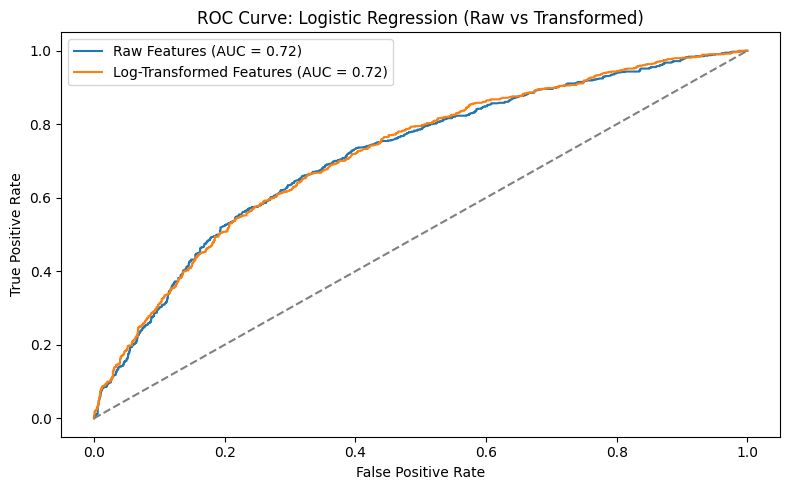

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the encoded and cleaned dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")

# Features and target
features = ["age", "juv_misd_count", "juv_fel_count", "priors_count", 
            "sex_encoded", "c_charge_degree_encoded", "c_charge_desc_encoded"]
target = "is_recid"

# Create a log-transformed version of the numeric features
df_transformed = df.copy()
for col in ["age", "juv_misd_count", "juv_fel_count", "priors_count"]:
    df_transformed[col] = np.log1p(df_transformed[col])

# Train/test split (same split for both versions)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
X_train_log, X_test_log, _, _ = train_test_split(df_transformed[features], df_transformed[target], test_size=0.2, random_state=42)

# Train logistic regression models
model_raw = LogisticRegression(max_iter=1000)
model_log = LogisticRegression(max_iter=1000)

model_raw.fit(X_train_raw, y_train)
model_log.fit(X_train_log, y_train)

# Predict and evaluate
y_pred_raw = model_raw.predict(X_test_raw)
y_pred_log = model_log.predict(X_test_log)

y_prob_raw = model_raw.predict_proba(X_test_raw)[:, 1]
y_prob_log = model_log.predict_proba(X_test_log)[:, 1]

# Accuracy & AUC
acc_raw = accuracy_score(y_test, y_pred_raw)
auc_raw = roc_auc_score(y_test, y_prob_raw)

acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_prob_log)

# Print results
print("Without Transformation - Accuracy:", round(acc_raw, 3), "| AUC:", round(auc_raw, 3))
print("With Log1p Transformation - Accuracy:", round(acc_log, 3), "| AUC:", round(auc_log, 3))

# Optional: ROC Curve Plot
fpr_raw, tpr_raw, _ = roc_curve(y_test, y_prob_raw)
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)

plt.figure(figsize=(8, 5))
plt.plot(fpr_raw, tpr_raw, label=f'Raw Features (AUC = {auc_raw:.2f})')
plt.plot(fpr_log, tpr_log, label=f'Log-Transformed Features (AUC = {auc_log:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve: Logistic Regression (Raw vs Transformed)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("../reports/roc_comparison_logreg.png")
plt.show()


The log transformation did not improve accuracy and AUC meaningfully. Another approach is to only log-transform feature age (as it resembles a log-normal distribution) and keep all other features raw. 

In [91]:
# Copy the original dataframe
df_age_log = df.copy()

# Apply log1p to 'age' only
df_age_log["age"] = np.log1p(df_age_log["age"])

# Train/test split
from sklearn.model_selection import train_test_split
X = df_age_log[features]
y = df_age_log["is_recid"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Log-Transformed Age Only — Accuracy:", round(acc, 4), "| AUC:", round(auc, 3))


Log-Transformed Age Only — Accuracy: 0.6901 | AUC: 0.717


Fairness analysis: To understand how recidivism is distributed across groups


Recidivism rate by sex:
 sex_label
female    0.378
male      0.259
Name: is_recid, dtype: float64
Recidivism rate by age group:
 age_group
<25      0.446
25-45    0.363
>45      0.242
Name: is_recid, dtype: float64

Recidivism rate by priors_group:
 priors_group
0 priors      0.211
1-5 priors    0.354
>5 priors     0.569
Name: is_recid, dtype: float64

Chi² test: sex_label vs is_recid
Chi² = 103.921 | p-value = 0.0
→ Statistically significant relationship between sex label and recidivism

Chi² test: age group vs is_recid
Chi² = 213.04 | p-value = 0.0
→ Statistically significant relationship between age group and recidivism

Chi² test: priors_group vs is_recid
Chi² = 724.539 | p-value = 0.0
→ Statistically significant relationship between age group and recidivism

Intersectional recidivism rates (age group x sex):
 sex_label  female   male
age_group               
<25         0.483  0.304
25-45       0.386  0.274
>45         0.258  0.172

Intersectional recidivism rates (priors group x

C:\Users\wastl\AppData\Local\Temp\ipykernel_19928\3812678839.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recid_by_age = df.groupby("age_group")["is_recid"].mean().round(3)
C:\Users\wastl\AppData\Local\Temp\ipykernel_19928\3812678839.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recid_by_priors = df.groupby("priors_group")["is_recid"].mean().round(3)
C:\Users\wastl\AppData\Local\Temp\ipykernel_19928\3812678839.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tru

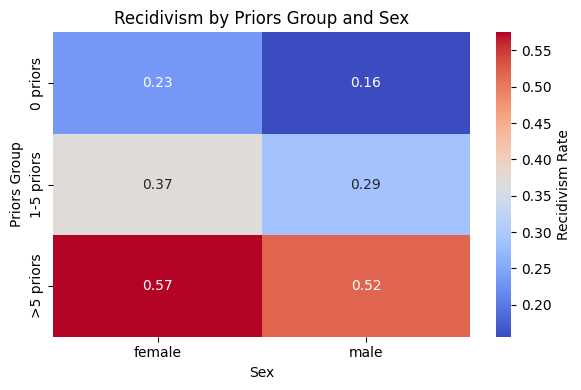

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Load dataset
df = pd.read_csv("../data/cox_violent_parsed_filt_dedup_featureselected_cleaned_encoded.csv")

# Map sex for readability
df["sex_label"] = df["sex_encoded"].map({0: "female", 1: "male"})

# Create age group categories
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 25, 45, df["age"].max()],
    labels=["<25", "25-45", ">45"],
    right=False
)

# Create prior count categories
df["priors_group"] = pd.cut(
    df["priors_count"],
    bins=[-1, 0, 5, df["priors_count"].max()],
    labels=["0 priors", "1-5 priors", ">5 priors"]
)

# Recidivism rate by sex
recid_by_sex = df.groupby("sex_label")["is_recid"].mean().round(3)
print("\nRecidivism rate by sex:\n", recid_by_sex)

# Recidivism rate by age group
recid_by_age = df.groupby("age_group")["is_recid"].mean().round(3)
print("Recidivism rate by age group:\n", recid_by_age)

# Recidivism rate by prior count categories
recid_by_priors = df.groupby("priors_group")["is_recid"].mean().round(3)
print("\nRecidivism rate by priors_group:\n", recid_by_priors)

# Chi-squared test (sex_label vs is_recid)
contingency_sex = pd.crosstab(df["sex_label"], df["is_recid"])
chi2_sex, p_sex, _, _ = chi2_contingency(contingency_sex)

# Chi-squared test (age_group vs is_recid)
contingency_age = pd.crosstab(df["age_group"], df["is_recid"])
chi2_age, p_age, _, _ = chi2_contingency(contingency_age)

# Chi-squared test (priors_group vs is_recid)
contingency_prior = pd.crosstab(df["priors_group"], df["is_recid"])
chi2_prior, p_prior, _, _ = chi2_contingency(contingency_prior)

print("\nChi² test: sex_label vs is_recid")
print("Chi² =", round(chi2_sex, 3), "| p-value =", round(p_sex, 4))
if p_sex < 0.05:
    print("→ Statistically significant relationship between sex label and recidivism")
else:
    print("→ No significant dependence")

print("\nChi² test: age group vs is_recid")
print("Chi² =", round(chi2_age, 3), "| p-value =", round(p_age, 4))
if p_age < 0.05:
    print("→ Statistically significant relationship between age group and recidivism")
else:
    print("→ No significant dependence")

print("\nChi² test: priors_group vs is_recid")
print("Chi² =", round(chi2_prior, 3), "| p-value =", round(p_prior, 4))
if p_prior < 0.05:
    print("→ Statistically significant relationship between age group and recidivism")
else:
    print("→ No significant dependence")

# Intersectional rates (age group x sex)
intersectional = df.groupby(["age_group", "sex_label"])["is_recid"].mean().round(3).unstack()
print("\nIntersectional recidivism rates (age group x sex):\n", intersectional)

# Intersectional rates (group by priors x sex)
intersectional_priors = df.groupby(["priors_group", "sex_label"])["is_recid"].mean().round(3).unstack()
print("\nIntersectional recidivism rates (priors group x sex):\n", intersectional_priors)


# Heatmap Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(intersectional_priors, annot=True, cmap="coolwarm", cbar_kws={'label': 'Recidivism Rate'})
plt.title("Recidivism by Priors Group and Sex")
plt.ylabel("Priors Group")
plt.xlabel("Sex")
plt.tight_layout()
plt.savefig("../reports/recidivism_by_sex_priors_heatmap.png")
plt.show()


Test possible bias at sex_label vs. is_recid with data including duplicates. 

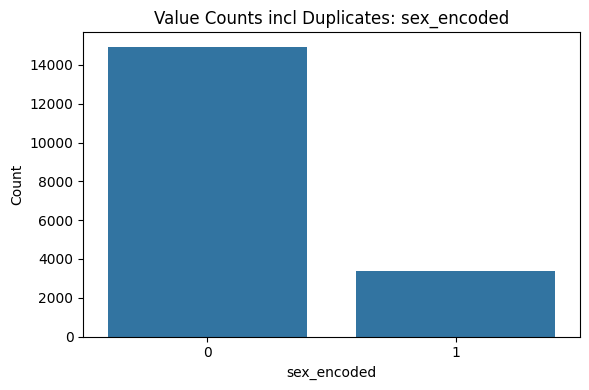


Recidivism rate by sex:
 sex_label
female    0.438
male      0.314
Name: is_recid, dtype: float64

Chi² test: sex_label vs is_recid
Chi² = 158.584 | p-value = 0.0
→ Statistically significant relationship between sex label and recidivism


In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Load dataset
df = pd.read_csv("../data/cox-violent-parsed_filt.csv")

# Label encode categorical features
df["sex_encoded"], sex_mapping = pd.factorize(df["sex"])
df["c_charge_degree_encoded"], degree_mapping = pd.factorize(df["c_charge_degree"])
df["c_charge_desc_encoded"], charge_mapping = pd.factorize(df["c_charge_desc"])

# Select final modeling features (encoded only)
df_encoded = df[[
    "age", "juv_misd_count", "juv_fel_count", "priors_count",
    "sex_encoded", "c_charge_degree_encoded", "c_charge_desc_encoded", "is_recid"
]]

# Save to CSV
encoded_path = "../data/cox-violent-parsed_filt_incl_duplicates_encoded.csv"
df_encoded.to_csv(encoded_path, index=False)


# Categorical feature counts (raw values for human readability)
categorical_features = ["sex_encoded"]

for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Value Counts incl Duplicates: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"../reports/value_counts_{col}.png")
    plt.show()
    plt.close()

# Map sex for readability
df["sex_label"] = df["sex_encoded"].map({0: "female", 1: "male"})

# Recidivism rate by sex
recid_by_sex = df.groupby("sex_label")["is_recid"].mean().round(3)
print("\nRecidivism rate by sex:\n", recid_by_sex)

# Chi-squared test (sex_label vs is_recid)
contingency_sex = pd.crosstab(df["sex_label"], df["is_recid"])
chi2_sex, p_sex, _, _ = chi2_contingency(contingency_sex)

print("\nChi² test: sex_label vs is_recid")
print("Chi² =", round(chi2_sex, 3), "| p-value =", round(p_sex, 4))
if p_sex < 0.05:
    print("→ Statistically significant relationship between sex label and recidivism")
else:
    print("→ No significant dependence")